# Assignment 3 - Predictive analysis : Regression

**Group number**: A-5 <br>
**Name student**: Zanou Rih & Sanaa El Marbouh<br>
**Student Number**: 300178068 & 300267783 <br>

##1. Introduction
The goal of this report is to demonstrate the use of regression in the context of a predictive analysis.
##2. Dataset Description - Housing Prices Regression

&#128279; **Link**: https://www.kaggle.com/datasets/denkuznetz/housing-prices-regression<br>
&#128100; **Author**: Den Kuznetz <br>

**Size**: 12 Columns, 500 rows <br>
**Description**:  <br>
This dataset is synthetically generated for the purpose of demonstrating a regression problem for predicting housing prices. The data was created by simulating key real estate factors such as property size, number of bedrooms and bathrooms, year built, and other features that commonly influence property values.

While this dataset does not come from a real-world source, it is designed to replicate the structure and trends found in real estate markets, providing an ideal starting point for predictive modeling.

**Key Features**: <br>
ID: A unique identifier for each property.

Square_Feet: The area of the property in square meters.

Num_Bedrooms: The number of bedrooms in the property.

Num_Bathrooms: The number of bathrooms in the property.

Num_Floors: The number of floors in the property.

Year_Built: The year the property was built.

Has_Garden: Indicates whether the property has a garden (1 for yes, 0 for no).

Has_Pool: Indicates whether the property has a pool (1 for yes, 0 for no).

Garage_Size: The size of the garage in square meters.

Location_Score: A score from 0 to 10 indicating the quality of the neighborhood (higher scores indicate better neighborhoods).

Distance_to_Center: The distance from the property to the city center in kilometers.

Price: The target variable that represents the price of the property. This is the value we aim to predict.


In [ ]:
# IMPORT STATEMENTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from datetime import datetime

from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# raw file URL from github
git_url_ds = "https://raw.githubusercontent.com/zanoudev/csi4142-ds/refs/heads/master/real_estate_dataset.csv"

#load DS
ds = pd.read_csv(git_url_ds)

# display the first few rows
ds.head()

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386
2,3,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.696880
3,4,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.655996
4,5,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.142523


##3. Regression Empirical Study with Linear Regression

###3.1 Data Cleaning and Imputation

In [ ]:
# PRESENCE CHECK (MISSING VALUES)
missing_values = ds.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values >= 0])



Missing values in each column:
ID                    0
Square_Feet           0
Num_Bedrooms          0
Num_Bathrooms         0
Num_Floors            0
Year_Built            0
Has_Garden            0
Has_Pool              0
Garage_Size           0
Location_Score        0
Distance_to_Center    0
Price                 0
dtype: int64


&#x2705; NO MISSING VALUES

In [ ]:
# RANGE CHECK
current_year = pd.Timestamp.now().year
ranges = {
    'Square_Feet': (10, 10000),
    'Num_Bedrooms': (0, 20),
    'Num_Bathrooms': (0, 20),
    'Num_Floors': (1, 10),
    'Year_Built': (1800, current_year),
    'Has_Garden': (0, 1),
    'Has_Pool': (0, 1),
    'Garage_Size': (0, 500),
    'Location_Score': (0, 10),
    'Distance_to_Center': (0, 1000),
    'Price': (1000, 1e8)
}

for column, (min_val, max_val) in ranges.items():
    out_of_range = ~ds[column].between(min_val, max_val)
    if out_of_range.any():
        print(f"Out-of-range values detected in '{column}':")
        print(ds.loc[out_of_range, ['ID', column]])
        # Handle out-of-range values (e.g., set to NaN or remove rows)
        ds.loc[out_of_range, column] = np.nan
    else:
        print(f"No out-of-range values detected in '{column}'.")

No out-of-range values detected in 'Square_Feet'.
No out-of-range values detected in 'Num_Bedrooms'.
No out-of-range values detected in 'Num_Bathrooms'.
No out-of-range values detected in 'Num_Floors'.
No out-of-range values detected in 'Year_Built'.
No out-of-range values detected in 'Has_Garden'.
No out-of-range values detected in 'Has_Pool'.
No out-of-range values detected in 'Garage_Size'.
No out-of-range values detected in 'Location_Score'.
No out-of-range values detected in 'Distance_to_Center'.
No out-of-range values detected in 'Price'.


&#x2705; NO OUT OF RANGE VALUES

###3.2 Categorical feature encoding
The dataset does not contain any categorical features. The attributes "Has_Garden" and "Has_Pool" are technically already encoded into **0 = no** and **1 = yes**

###3.3 EDA and Outlier detection
We will first visualize the distribution of each attribute to detect any outliers.

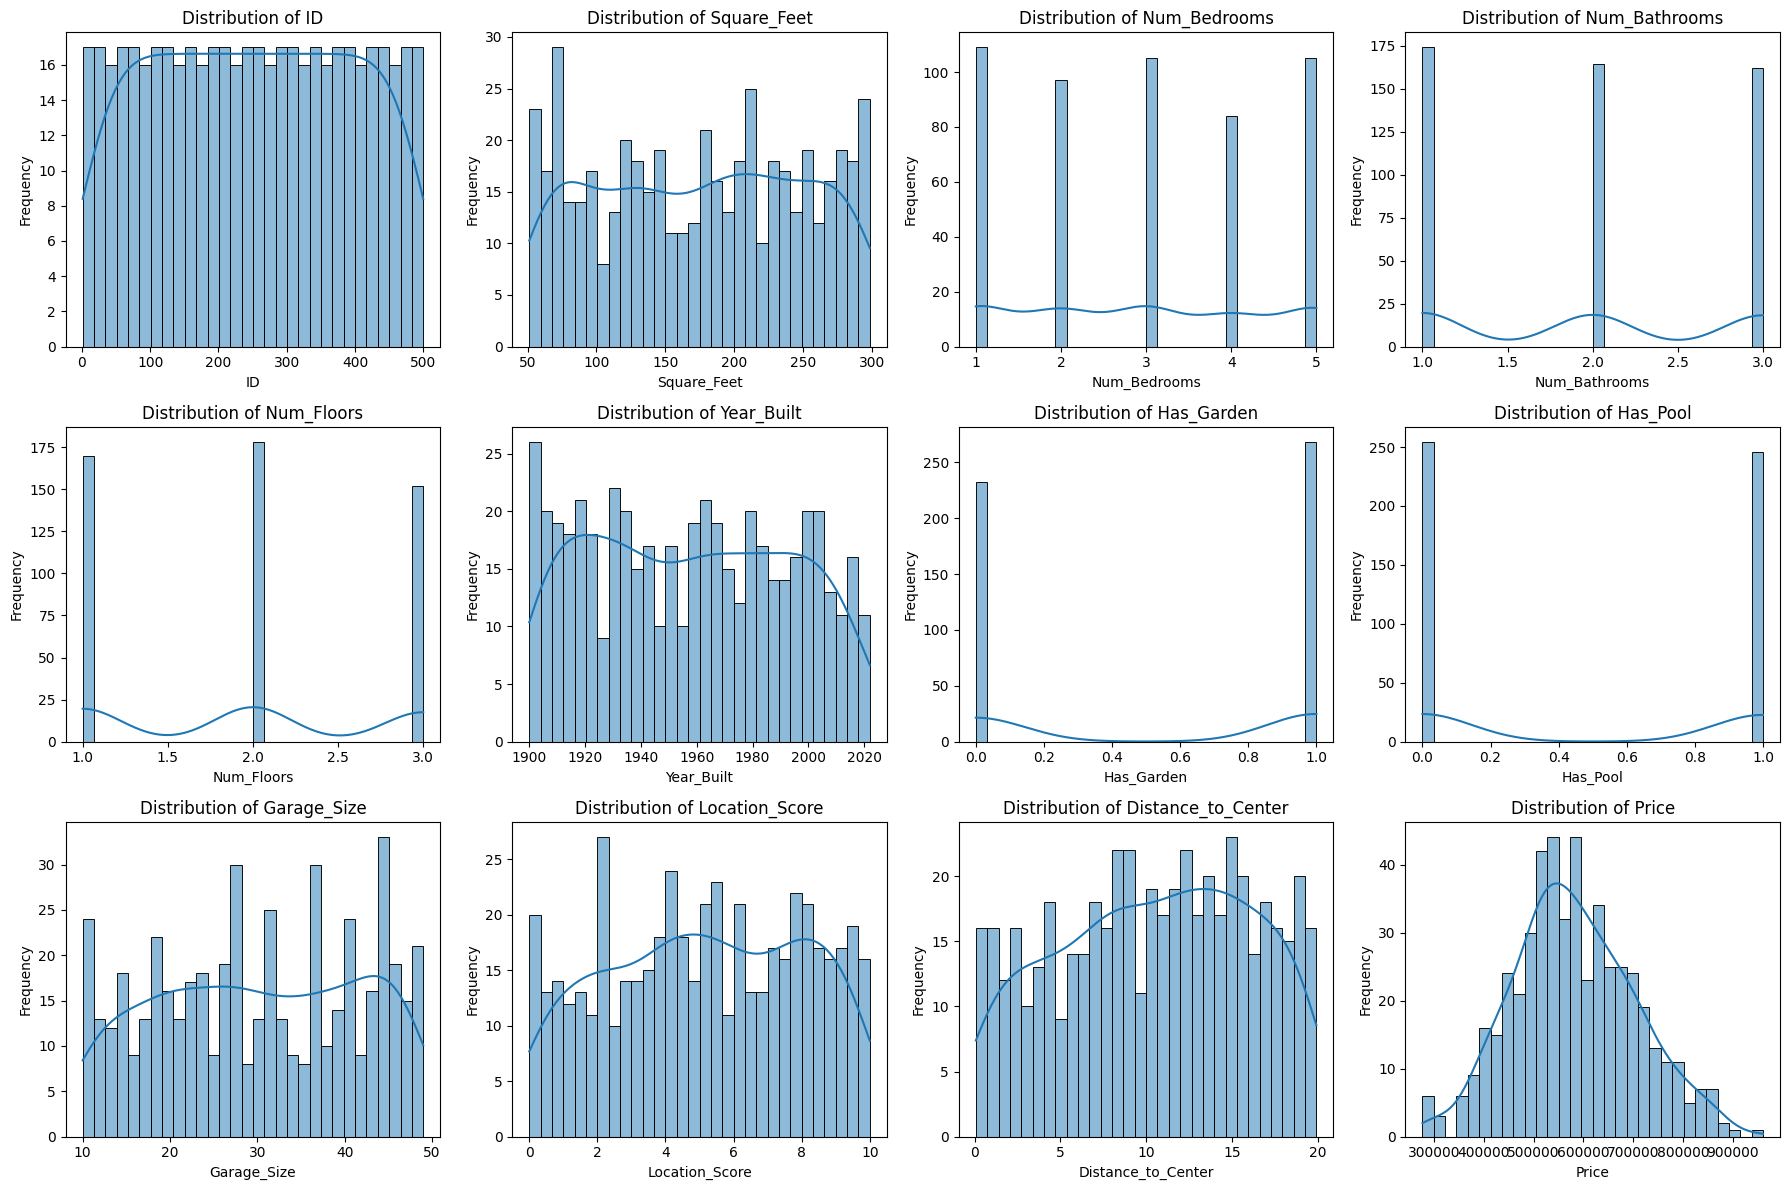

In [ ]:
rows, cols = 3, 4

# subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()  # Flatten the axes array to loop through it easily

for i, column in enumerate(ds.columns):
    sns.histplot(ds[column].dropna(), kde=True, bins=30, edgecolor='black', ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Distribution of {column}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

####**Interpretation of EDA:**

According to the plots, all the features seem to have a normal distribution with no visible outliers, except the Price feature.

Let's do LOF detection on the "Price" feature.

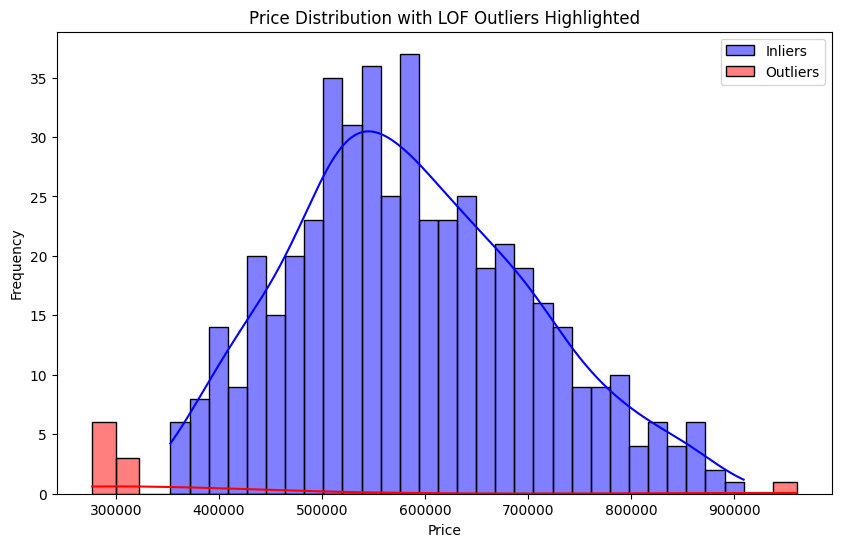

Number of outliers detected: 10


,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price,Outlier_Flag
90,91,79.898561,1,1,2,1920,0,1,13,2.320398,0.906386,276892.470136,-1
102,103,128.588995,1,2,3,1901,0,0,36,0.460567,8.521420,299477.849956,-1
148,149,62.869688,1,1,2,1983,0,0,41,1.438144,9.262294,280166.110934,-1
150,151,277.066471,5,2,3,2019,1,1,30,9.037576,13.094182,960678.274291,-1
171,172,54.146957,2,1,1,1935,1,0,30,7.739062,4.021303,320014.707134,-1
224,225,116.300592,1,2,1,1920,1,0,14,5.600917,9.882953,299387.116387,-1
294,295,81.765128,1,2,1,1910,0,1,11,9.349944,17.837862,291630.925913,-1
356,357,56.627828,2,2,1,1938,1,0,33,1.170660,10.455203,301823.920507,-1
409,410,72.821669,1,1,2,1928,0,1,27,8.849643,7.530606,298871.665267,-1
434,435,71.026702,1,1,1,1931,0,1,45,5.350255,15.257867,318416.124369,-1


In [ ]:
# Applying LOF to "Price" feature
X_feature = ds[["Price"]]

# contamination rate of 2% (to adjust)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
outlier_flags = lof.fit_predict(X_feature)

# Store results
ds["Outlier_Flag"] = outlier_flags

# Visualize Price distribution with outliers highlighted
plt.figure(figsize=(10, 6))
sns.histplot(ds[ds["Outlier_Flag"] == 1]["Price"], bins=30, kde=True, color="blue", edgecolor="black", label="Inliers")
sns.histplot(ds[ds["Outlier_Flag"] == -1]["Price"], bins=30, kde=True, color="red", edgecolor="black", label="Outliers")

plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Price Distribution with LOF Outliers Highlighted")
plt.legend()
plt.show()

# Display detected outliers
outliers_detected = ds[ds["Outlier_Flag"] == -1]
print(f"Number of outliers detected: {len(outliers_detected)}")
display(outliers_detected)

# num_outliers = (ds["Outlier_Flag"] == -1).sum()
# print(f"Number of outliers detected in Price: {num_outliers}")

# outliers_detected = ds[ds["Outlier_Flag"] == -1]
# display(outliers_detected)

####**Interpretation of LOF:**

The Local Outlier Factor (LOF) identified 10 outliers in the dataset, but after reviewing their feature distributions and values, they appear to represent rare but legitimate properties rather than errors or extreme anomalies. Since these data points provide valuable insights into unique cases, they were retained in the dataset without modification.

###3.4 Predictive Analysis: Linear Regression

Coefficients: [ 1017.8033615  50685.18802324 29947.99535338 21134.019516
  1518.24127836 30455.50229721 47415.25384258  1135.27772018
  4805.36341592 -1944.89818498]
Intercept: -2896629.2285577655
Mean Squared Error: 358450022.4153196
R-squared: 0.9759766171790658
          Actual      Predicted     Residuals
0  602134.816747  600567.637226   1567.179521
1  591425.135386  584428.342835   6996.792551
2  464478.696880  489803.791909 -25325.095029
3  583105.655996  587306.647780  -4200.991784
4  619879.142523  632796.566378 -12917.423855


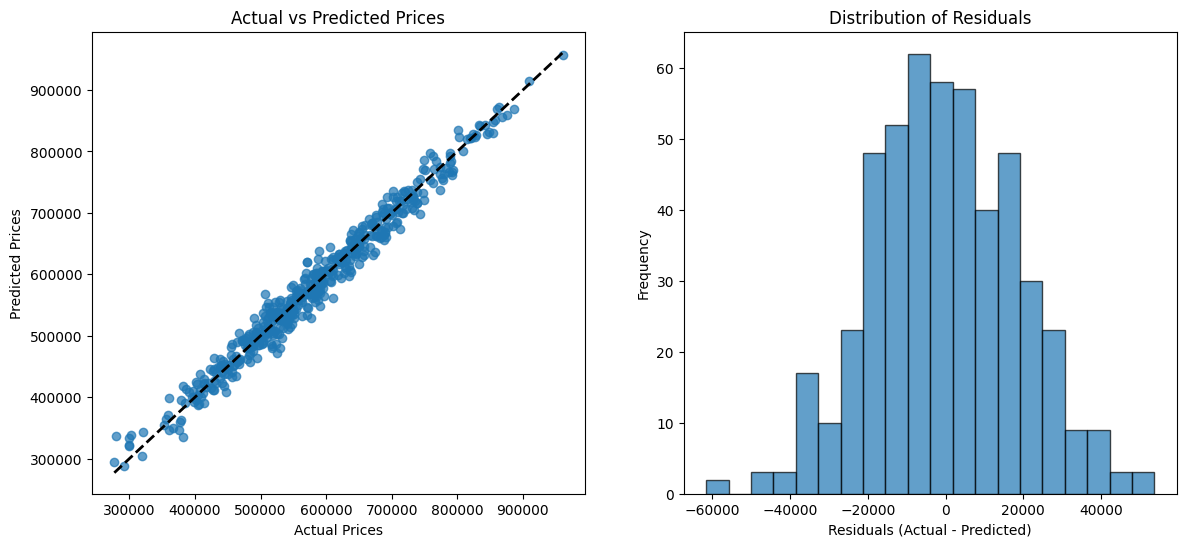

In [ ]:
# Init and fit LinearRegression Model

features = ['Square_Feet', 'Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors', 'Year_Built', 'Has_Garden', 'Has_Pool', 'Garage_Size', 'Location_Score', 'Distance_to_Center']
target = 'Price'

X = ds[features]
y = ds[target]

model = LinearRegression()
model = model.fit(X, y)

# print learned coef and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

y_pred = model.predict(X)

# print mean squared error and r2 score
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# created a df to compare actual data and predicted values
comparison_df = pd.DataFrame({
    'Actual': y,
    'Predicted': y_pred,
    'Residuals': y - y_pred
})
print(comparison_df.head())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot: Actual vs Predicted values
axes[0].scatter(y, y_pred, alpha=0.7)
axes[0].set_xlabel("Actual Prices")
axes[0].set_ylabel("Predicted Prices")
axes[0].set_title("Actual vs Predicted Prices")
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Diagonal line for reference

# Plot: Distribution of residuals to check for any patterns
axes[1].hist(comparison_df['Residuals'], bins=20, edgecolor='k', alpha=0.7)
axes[1].set_xlabel("Residuals (Actual - Predicted)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Residuals")

plt.show()

###3.5 Feature Engineering


####3.5.1 First Additional Feature (Ratio): Garage_to_Size_Ratio


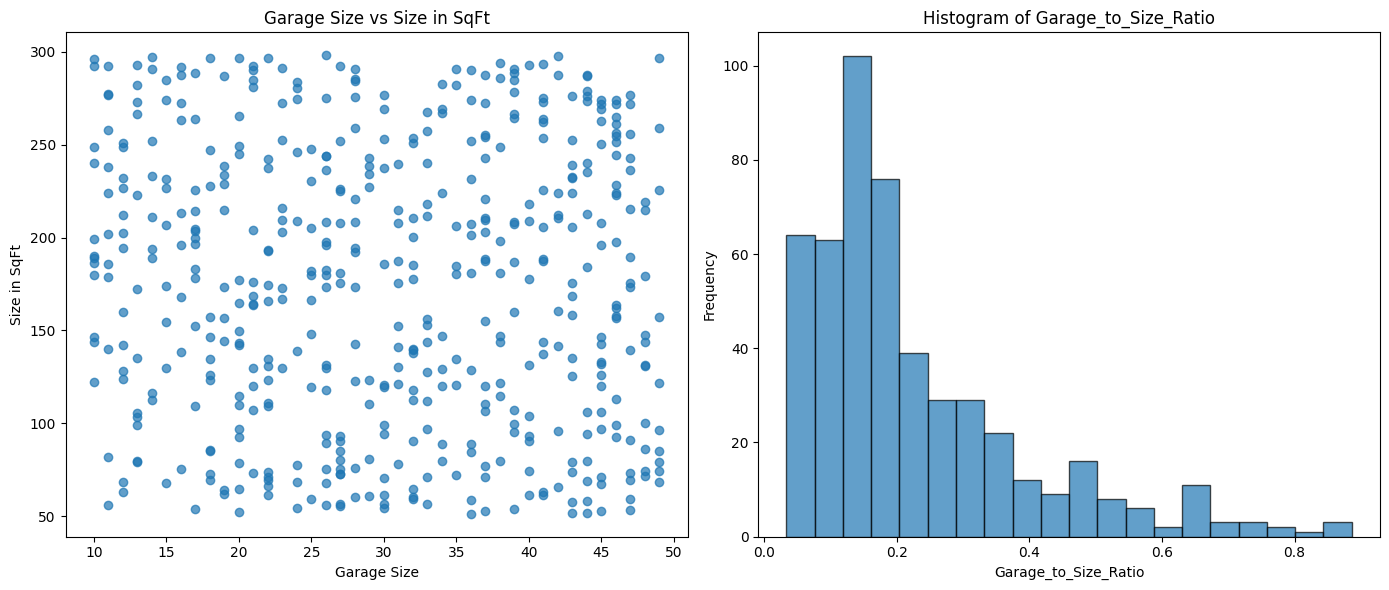

In [ ]:
ds_copy = ds.copy()
ds_copy["Garage_to_Size_Ratio"] = ds_copy['Garage_Size'] / ds_copy['Square_Feet']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Scatterplot: Garage_Size vs. Square_Feet
axes[0].scatter(ds_copy['Garage_Size'], ds_copy['Square_Feet'], alpha=0.7)
axes[0].set_xlabel("Garage Size")
axes[0].set_ylabel("Size in SqFt")
axes[0].set_title("Garage Size vs Size in SqFt")

# Histogram of Garage_to_Size Feature
axes[1].hist(ds_copy['Garage_to_Size_Ratio'], bins=20, edgecolor='k', alpha=0.7)
axes[1].set_xlabel("Garage_to_Size_Ratio")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of Garage_to_Size_Ratio")

plt.tight_layout()
plt.show()

####3.5.2 Second Additional Feature (Age): Building_Age

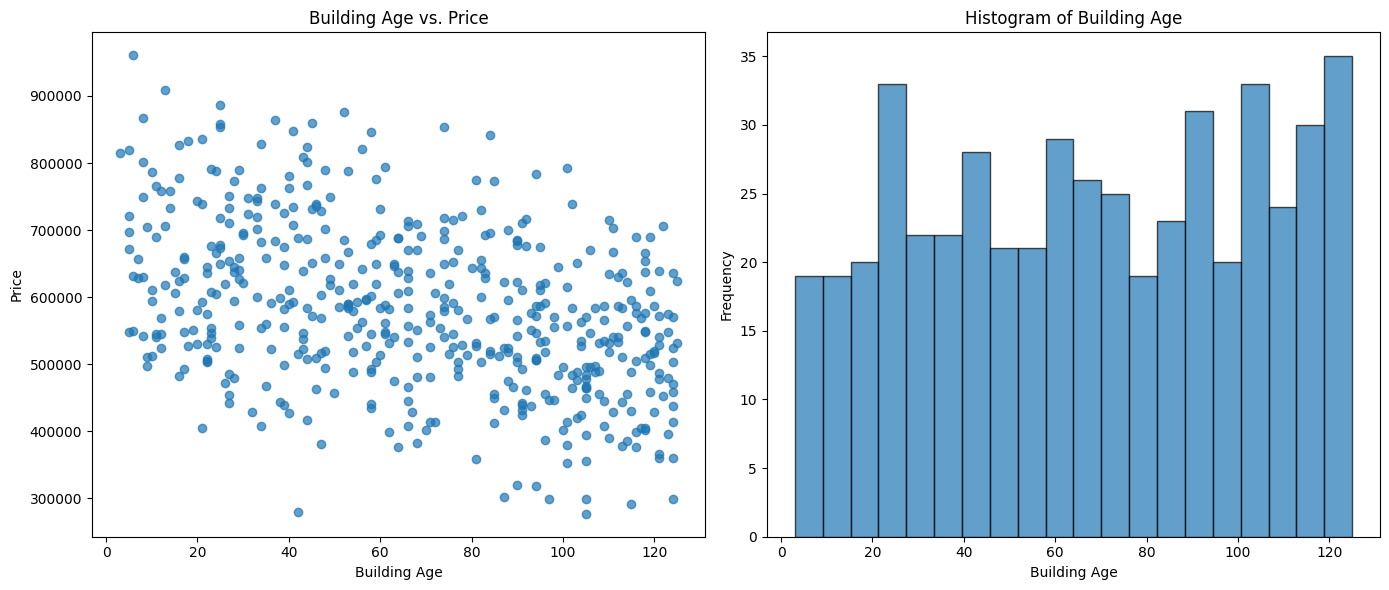

In [ ]:
current_year = datetime.now().year
ds_copy['Building_Age'] = current_year - ds_copy['Year_Built']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Scatterplot: Building Age vs. Price
axes[0].scatter(ds_copy['Building_Age'], ds_copy['Price'], alpha=0.7)
axes[0].set_xlabel("Building Age")
axes[0].set_ylabel("Price")
axes[0].set_title("Building Age vs. Price")

# Histogram of Building_Age
axes[1].hist(ds_copy['Building_Age'], bins=20, edgecolor='k', alpha=0.7)
axes[1].set_xlabel("Building Age")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of Building Age")

plt.tight_layout()
plt.show()


###3.6 Empirical Study

We will split the data into the following subsets:
* training set (80%)
* test set (20%)

In [ ]:
# SPLITTING THE DATASET

# training set DR and test set DT
train_set, test_set = train_test_split(ds, test_size=0.2, random_state=42)  # DT (Test set)

# Ensure training set (DR) is separate from test set
DR = train_set.copy()

# Print the sizes
print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")


Training set size: 400
Test set size: 100


We will use MSE and R2 as our evaluation metrics.

In [ ]:
# note: while we previoudsly decided to not remove the outliers, we will do so in this study just for the sake of comparison
def modify_outliers(df):
    """function to remove outliers based on z-score."""
    from scipy.stats import zscore
    df_clean = df[(np.abs(zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]
    return df_clean

def feature_engineering(df):
    """Add feature engineering variables: Garage_to_Size_Ratio and Building_Age."""
    df = df.copy()
    df["Garage_to_Size_Ratio"] = df["Garage_Size"] / df["Square_Feet"]
    current_year = datetime.now().year
    df["Building_Age"] = current_year - df["Year_Built"]
    return df

# different versions of DR with mods
DR1 = modify_outliers(DR)
DR2 = feature_engineering(DR)
DR3 = DR.copy()  # baseline
DRX_versions = [DR1, DR2, DR3]

# 4-FOLD CROSS-VALIDATION ON EACH DRX
kf = KFold(n_splits=4, shuffle=True, random_state=42)
model_names = ["LinearRegression", "Ridge", "Lasso"]
models = [LinearRegression(), Ridge(alpha=1.0), Lasso(alpha=0.1)]

best_score = float('inf')
best_model = None
best_DR = None

results = []

for i, DRX in enumerate(DRX_versions):
    X = DRX.drop(columns=["Price"])
    y = DRX["Price"]

    for model, model_name in zip(models, model_names):
        mse_scores = []

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            mse_scores.append(mean_squared_error(y_val, y_pred))

        avg_mse = np.mean(mse_scores)
        results.append({"DRX": i + 1, "Model": model_name, "MSE": avg_mse})

        print(f"Avg MSE for DR{i+1} with {model_name}: {avg_mse}")

        # select best model and training set
        if avg_mse < best_score:
            best_score = avg_mse
            best_model = model
            best_DR = DRX
            best_model_name = model_name

# TRAIN THE BEST MODEL ON FULL DR AND TEST ON DT
X_best = best_DR.drop(columns=["Price"])
y_best = best_DR["Price"]
best_model.fit(X_best, y_best)

# TEST ON DT
X_test = test_set.drop(columns=["Price"])
y_test = test_set["Price"]
y_pred_test = best_model.predict(X_test)

# Final Test Evaluation
final_mse = mean_squared_error(y_test, y_pred_test)
final_r2 = r2_score(y_test, y_pred_test)

print(f"\nBest Model: {best_model_name} on DR{DRX_versions.index(best_DR) + 1}")
print(f"Final Test MSE: {final_mse}")
print(f"Final Test R2: {final_r2}")

# display all results
results_df = pd.DataFrame(results)
display(results_df)

Avg MSE for DR1 with LinearRegression: 370676080.2714719
Avg MSE for DR1 with Ridge: 370717985.40201515
Avg MSE for DR1 with Lasso: 370676101.620666
Avg MSE for DR2 with LinearRegression: 374430123.2905163
Avg MSE for DR2 with Ridge: 372818822.58327717
Avg MSE for DR2 with Lasso: 374424586.1777275
Avg MSE for DR3 with LinearRegression: 379411890.601486
Avg MSE for DR3 with Ridge: 376577153.6389419
Avg MSE for DR3 with Lasso: 379403615.7409858

Best Model: LinearRegression on DR1
Final Test MSE: 446340484.20024544
Final Test R2: 0.9703267273435443


,DRX,Model,MSE
0,1,LinearRegression,3.706761e+08
1,1,Ridge,3.707180e+08
2,1,Lasso,3.706761e+08
3,2,LinearRegression,3.744301e+08
4,2,Ridge,3.728188e+08
5,2,Lasso,3.744246e+08
6,3,LinearRegression,3.794119e+08
7,3,Ridge,3.765772e+08
8,3,Lasso,3.794036e+08


###3.7 Result Analysis

**Cross-Validation Results:**

- Best cross-validation MSE: 370,676,080 (DR1 with Linear Regression).
- Feature Engineering (DR2) did not improve performance, MSE slightly increased.
- Baseline (DR3) performed the worst, confirming that modifications help.
- Regularization (Ridge, Lasso) did not significantly improve MSE, meaning overfitting was not a major issue.

**Impact of Outlier Detection & Feature Engineering:**

- Outlier removal (DR1) resulted in the best model which suggests that extreme values slightly impacted performance.
- Feature engineering (DR2) did not outperform outlier removal which indicates that "Garage_to_Size_Ratio" and "Building_Age" might not be strong predictors or need further tuning.
- Baseline (DR3) performed the worst, confirming that some preprocessing is necessary.

**Comparison to Unseen Test Set:**

- Final Test MSE (446,340,484) is higher than Cross-Validation MSE (370,676,080) which indicates a slight generalization gap.
- High R2 (0.97) suggests the model still explains most of the variance but may struggle slightly on new data.
- Possible cause of performance drop: Test set might contain different property distributions or some outlier effects were still present.

## References
*   https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
